<h1>Lecture 6, October 6, 2025 </h1>

<h1> Estimation of VAR models </h1>

Marta Boczon

Department of Economics

Copnehagen Business School

mbo.eco@cbs.dk

In [1]:
#install.packages("quantmod")
#install.packages("fredr")
#install.packages("ggfortify")
#install.packages('urca')
#install.packages("tseries")
#install.packages("forecast")
#install.packages("dynlm")
#install.packages("stargazer")
#install.packages("pracma")
#install.packages("dLagM")
#install.packages("gets")
#install.packages("car")
#install.packages("lmtest")
#install.packages("vars")
options(warn=-1)

<div style="background-color:#e6f2ff; padding:10px; border-radius:5px;">

Today we will discuss <b>Vector Autoregression (VAR) models</b>, focusing in particular on the role of <b>real wage / labor compensation in Canada</b>.
We will build on the Canadian GDP and hours worked in the manufacturing sector data introduced earlier, and, in a bit, we will introduce a new variable: wages.
However, before we get there, let us circle back to last week’s material and practice one more time pseudo–out-of-sample forecasting.
    
</div>

In [21]:
# Import the dataset from a CSV file downloaded from FRED
gdp =read.csv("NGDPRSAXDCCAQ.csv")
# Convert the second column of the dataset into a time series object
tsgdp = ts(gdp[, 2], frequency = 4, start = c(1961, 1))
# Transform the series into (approximate) percentage changes
dgdp = diff(log(tsgdp)) * 100

In [22]:
# Import the dataset from a CSV file downloaded from FRED
hours = read.csv("HOHWMN02CAM065N.csv")
# Convert the second column of the dataset into a time series object
tshours = ts(hours[, 2], frequency = 4, start = c(1960, 1))
# Transform the series into a change from the previous period
dhours = diff(tshours)

<div style="background-color:#e6f2ff; padding:10px; border-radius:5px;">
    
<h2>Exercise 1 (15')</h2>

The code below can be found in Lecture 5. We used it to compute recursive out of sample forecasts for AR(1). Modify the code below to find <b>the Mean Absolute Error and the Root Mean Square Forecast Error</b> for <b>1 and 2-step ahead</b> forecast of Canadian GDP growth rate using AR(1).

</div>    

In [23]:
# https://www.rdocumentation.org/packages/forecast/versions/8.16/topics/forecast
library(forecast)

# Length of sample 
T = length(dgdp)

# Container for results
results = data.frame()

# Initial estimation window
Tstar = 200

# Number of iterations
Tmax = T - Tstar

cat("Our data has", T, "observations.\n")
cat("We will keep the first", Tstar, "observations fixed for stability (initial estimation window).\n")
cat("From there, we add one observation at a time and forecast one step ahead at each iteration.\n")
cat("We will produce", Tmax, "out-of-sample 1-step-ahead forecasts, ending at observation", T, ".\n\n")


for (i in 1:Tmax) {
  # Expand window estimation: use data up to time Tstar + i - 1
  model = arima(dgdp[1:(Tstar + i - 1)], order = c(1, 0, 0))
  
  # One-step-ahead forecast with a single 95% PI
  f = forecast::forecast(model, h = 1, level = 95)
  
  # Extract components (coerce to numeric to avoid ts attributes in arithmetic)
  f.mean = as.numeric(f$mean)              # point forecast y_{T+1|T}
  f.lower95 = as.numeric(f$lower)          # 95% lower bound
  f.upper95 = as.numeric(f$upper)          # 95% upper bound
  obs.val = as.numeric(dgdp[Tstar + i])    # actual y_{T+1}
  
  # Absolute forecast error
  f.error = abs(f.mean - obs.val)
  
  # Row to append
  temp = c(f.mean, f.lower95, f.upper95, obs.val, f.error)
  results = rbind(results, temp)
}

# Name the columns
names(results) = c("Mean forecast", "Lower bound 95%", "Upper bound 95%", "Actual value", "Absolute error")

# Quick peek at the first 6 interations
head(results)

# Quick peek at the last 6 iterations
tail(results)

# Save AR(1) rolling results
results.AR1 = results

# Mean Absolute Error (MAE)
mae.AR1 = mean(results.AR1[, "Absolute error"])

# Root Mean Squared Forecast Error (RMSFE)
rmsfe.AR1 = sqrt(mean((results.AR1[, "Mean forecast"] - results.AR1[, "Actual value"])^2))

cat("The MAE is", round(mae.AR1, 5), "and the RMSFE is", round(rmsfe.AR1, 5))

Our data has 256 observations.
We will keep the first 200 observations fixed for stability (initial estimation window).
From there, we add one observation at a time and forecast one step ahead at each iteration.
We will produce 56 out-of-sample 1-step-ahead forecasts, ending at observation 256 .



,Mean forecast,Lower bound 95%,Upper bound 95%,Actual value,Absolute error
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.8011480,-0.7919774,2.394273,0.18136394,0.6197841
2,0.5725205,-1.0189328,2.163974,1.35896277,0.7864423
3,1.0346830,-0.5565105,2.625876,0.79159116,0.2430918
4,0.8136804,-0.7739418,2.401303,0.06311038,0.7505700
5,0.5283029,-1.0587520,2.115358,0.32454382,0.2037591
6,0.6279366,-0.9554827,2.211356,0.13675060,0.4911860


,Mean forecast,Lower bound 95%,Upper bound 95%,Actual value,Absolute error
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
51,0.7309076,-1.745116,3.206931,-0.03829651,0.7692042
52,0.7308181,-1.742088,3.203724,0.17659246,0.5542256
53,0.7335084,-1.735429,3.202446,0.62945465,0.1040538
54,0.7451791,-1.718907,3.209266,0.59438355,0.1507956
55,0.7436371,-1.715664,3.202938,0.50857420,0.2350629
56,0.7403866,-1.714256,3.195029,0.54794362,0.1924430


The MAE is 0.98796 and the RMSFE is 2.60835

<div style="background-color:#e6f2ff; padding:10px; border-radius:5px;">

<h2>Solution to Exercise 1</h2>
    
</div>    

In [24]:
# https://www.rdocumentation.org/packages/forecast/versions/8.16/topics/forecast
library(forecast)

# Length of sample 
T = length(dgdp)

# Initial estimation window
Tstar = 200

# Number of iterations
Tmax = T - Tstar

# Forecast horizon
h = 2

# Container for results
results = replicate(h, data.frame(), simplify = FALSE)

cat("Our data has", T, "observations.\n")
cat("We will keep the first", Tstar, "observations fixed for stability (initial estimation window).\n")
cat("From there, we add one observation at a time and forecast one step ahead at each iteration.\n")
cat("We will produce", Tmax, "out-of-sample 1-step-ahead forecasts, ending at observation", T, ".\n\n")


for (i in 1:Tmax) {
  # Expand window estimation: use data up to time Tstar + i - h
  model = arima(dgdp[1:(Tstar + i - h)], order = c(1, 0, 0))
  
  # One-step-ahead forecast with a single 95% PI
  f = forecast::forecast(model, h = h, level = 95)
  # Extract components (coerce to numeric to avoid ts attributes in arithmetic)
  f.mean = as.numeric(f$mean)              # point forecasts
  f.lower95 = as.numeric(f$lower)          # 95% lower bound
  f.upper95 = as.numeric(f$upper)          # 95% upper bound
  obs.val = as.numeric(dgdp[(Tstar + i + 1 - h) : (Tstar + i)])   # actual values
  # Absolute forecast error
  f.error = abs(f.mean - obs.val)
  # Row to append
    for (j in 1:h) {
         temp = c(f.mean[j], f.lower95[j], f.upper95[j], obs.val[j], f.error[j])
         results[[j]] = rbind(results[[j]], temp)
    }
}

for (j in 1:h) {
    colnames(results[[j]])= c("Mean forecast", "Lower bound 95%", "Upper bound 95%", "Actual value", "Absolute error")
    rownames(results[[j]]) = NULL
    
    # Quick peek at the first 6 interations
    # print(head(results[[j]]))
    
    # Quick peek at the last 6 iterations
    # print(tail(results[[j]]))
    
    # Mean Absolute Error (MAE)
    temp = mean(results[[j]][, "Absolute error"])
    cat("h=", j, "MAE=", round(temp, 5), "\n")
    
    # Root Mean Squared Forecast Error (RMSFE)
    temp = sqrt(mean((results[[j]][, "Absolute error"])^2))
    cat("h=", j,"RMSFE=", round(temp ,5), "\n")
}


Our data has 256 observations.
We will keep the first 200 observations fixed for stability (initial estimation window).
From there, we add one observation at a time and forecast one step ahead at each iteration.
We will produce 56 out-of-sample 1-step-ahead forecasts, ending at observation 256 .

h= 1 MAE= 0.98779 
h= 1 RMSFE= 2.60834 
h= 2 MAE= 0.9684 
h= 2 RMSFE= 2.21779 


<div style="background-color:#e6f2ff; padding:10px; border-radius:5px;">
    
<b>Wonderful!</b> <br> Now we can refocus on building a <b>VAR model</b>. We are going to construct a three-variable VAR model. Two of the three variables—GDP and hours worked—are already imported and transformed into stationary series. Now, we will import data ob wages and defalte it by Canadian CPI index.
    
</div>    

<div style="background-color:#e6f2ff; padding:12px; border-radius:6px; line-height:1.5;">
  <p><strong>1. Data:</strong> Hourly Earnings: Earnings: Economic Activity: Manufacturing: Total Economy for Canada (<code>CANHOUREAMISMEI</code>)</p>
  <p><strong>2. Source:</strong> Organization for Economic Co-operation and Development via FRED®</p>
  <p><strong>3. Frequency:</strong> Quarterly (aggregation method: Average)</p>
  <p><strong>4. Units:</strong> Index 2015 = 100</p>
  <p><strong>5. Seasonal Adjustment:</strong> Seasonally Adjusted</p>
  <p><a href="https://fred.stlouisfed.org/series/CANHOUREAMISMEI" target="_blank">View on FRED</a></p>
</div>


<div style="background-color:#e6f2ff; padding:12px 16px; border-radius:8px; line-height:1.6;">
  <p><strong>1. Data:</strong> Consumer Price Indices (CPIs, HICPs), COICOP 1999: Consumer Price Index: Total for Canada (<code>CANCPIALLMINMEI</code>)</p>
  <p><strong>2. Source:</strong> Organization for Economic Co-operation and Development via FRED®</p>
  <p><strong>3. Frequency:</strong> Quarterly (aggregation method: Average)</p>
  <p><strong>4. Units:</strong> Index 2015=100</p>
  <p><strong>5. Seasonal adjustment:</strong> Not Seasonally Adjusted</p>
  <p><a href="https://fred.stlouisfed.org/series/CANCPIALLMINMEI" target="_blank">View on FRED</a></p>
</div>


In [25]:
# Import the dataset from a CSV file downloaded from FRED
wages =read.csv("CANHOUREAMISMEI.csv")
# Convert the second column of the dataset into a time series object
tswages = ts(wages[, 2], frequency = 4, start = c(1961, 1))

In [26]:
# Import the dataset from a CSV file downloaded from FRED
cpi =read.csv("CANCPIALLMINMEI.csv")
# Convert the second column of the dataset into a time series object
tscpi = ts(cpi[, 2], frequency = 4, start = c(1914, 1))

In [27]:
# Align the two time series on their common time span and timestamps.
temp = ts.intersect(tswages, tscpi)
# Compute a REAL WAGE INDEX:
tswages = temp[,1] / temp[,2] * 100

<div style="background-color:#e6f2ff; padding:10px; border-radius:5px;">

<h2>Exercise 2 (15')</h2>

Transform real wages to a stationary series.
</div>  

<div style="background-color:#e6f2ff; padding:10px; border-radius:5px;">

<h2>Solution to Exercise 2</h2>
    
</div>    

In [28]:
# Calculate the number of observations in the time series object
nd = length(tswages)

# Print a message along with the number of observations
cat("There are", nd, "observations in our data set.")

There are 257 observations in our data set.

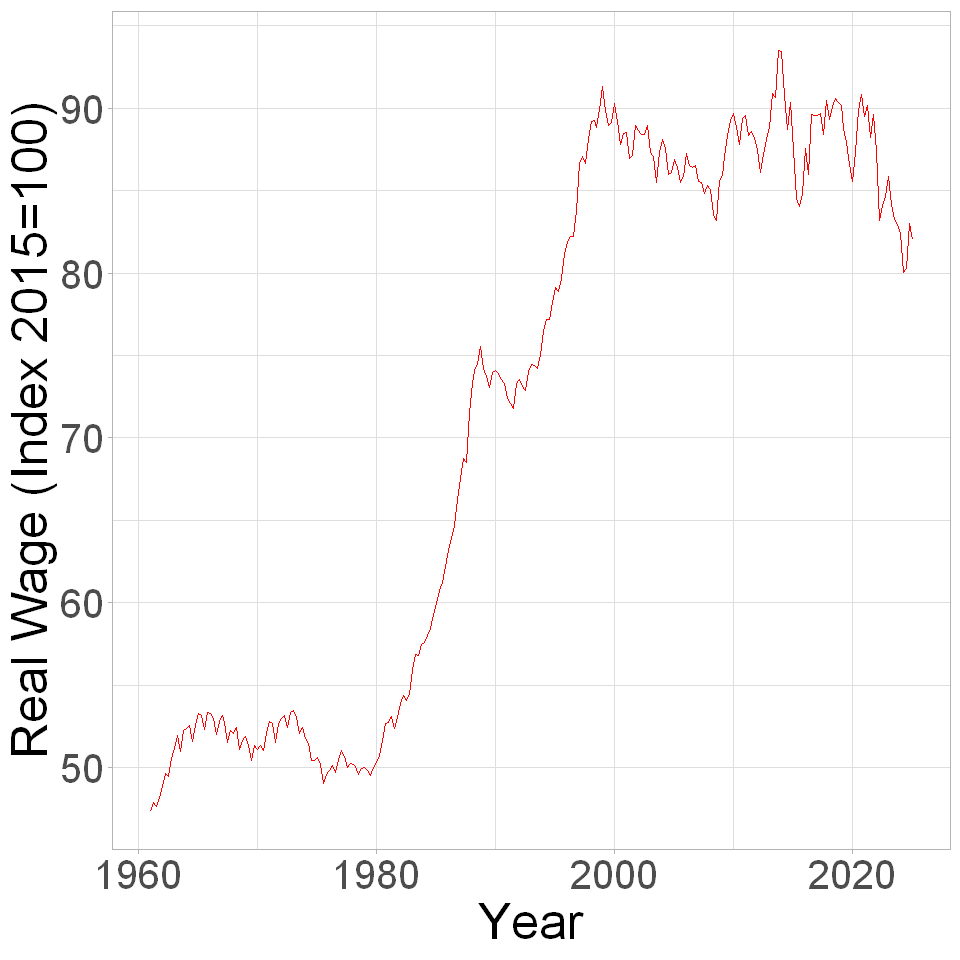

In [29]:
# Load required libraries
library(ggplot2)   # for plotting
library(ggfortify) # for autoplot of time series objects

# Set default figure size (width = 8, height = 8)
options(repr.plot.width = 8, repr.plot.height = 8)

# Create an initial time series plot of tspce in red
fig = autoplot(tswages, colour = 'red')

# Customize the plot
fig = fig +
  theme(aspect.ratio = 1) +                      # make plot square-shaped
  theme_light() +                                # use a light theme
  theme(aspect.ratio = 1) +                      # reinforce square aspect ratio
  theme(plot.margin = ggplot2::margin(0.2, 0.2, 0.2, 0.2, "cm")) + # adjust margins
  theme(text = element_text(size = 30)) +        # set large font size for readability
  labs(x = "Year") +                             # label x-axis
  labs(y = "Real Wage (Index 2015=100)")         # label y-axis

# Display the plot
fig


In [30]:
library(urca)
summary(ur.df(tswages, type='trend', lags=8, selectlags="AIC"))


############################################### 
# Augmented Dickey-Fuller Test Unit Root Test # 
############################################### 

Test regression trend 


Call:
lm(formula = z.diff ~ z.lag.1 + 1 + tt + z.diff.lag)

Residuals:
    Min      1Q  Median      3Q     Max 
-4.4380 -0.5102 -0.0191  0.4879  3.2507 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.5632472  0.4781869   1.178  0.24003    
z.lag.1     -0.0084397  0.0105710  -0.798  0.42545    
tt           0.0009547  0.0024227   0.394  0.69388    
z.diff.lag1  0.0683905  0.0643389   1.063  0.28888    
z.diff.lag2  0.0620587  0.0653942   0.949  0.34359    
z.diff.lag3  0.0368339  0.0629825   0.585  0.55922    
z.diff.lag4  0.1989248  0.0632956   3.143  0.00189 ** 
z.diff.lag5 -0.0138480  0.0636163  -0.218  0.82787    
z.diff.lag6 -0.2630739  0.0636725  -4.132    5e-05 ***
z.diff.lag7  0.0243001  0.0659069   0.369  0.71268    
z.diff.lag8  0.2078281  0.0658597   3.156  0.00181 **

<div style="background-color:lightyellow; padding:12px 16px; border-radius:8px; line-height:1.6;">
  <p><strong>ADF (with constant + trend): Interpretation</strong></p>

  <p><strong>From the output:</strong></p>
  <ul>
    <li>Test statistics: <strong>tau₃ = −0.7984</strong>, <strong>phi₂ = 1.0079</strong>, <strong>phi₃ = 0.7382</strong></li>
    <li>Critical values:
      <ul>
        <li><strong>tau₃:</strong> −3.98 (1%), −3.42 (5%), −3.13 (10%)</li>
        <li><strong>phi₂:</strong> 6.15 (1%), 4.71 (5%), 4.05 (10%)</li>
        <li><strong>phi₃:</strong> 8.34 (1%), 6.30 (5%), 5.36 (10%)</li>
      </ul>
    </li>
  </ul>

  <p><strong>Deterministic components:</strong> Both <strong>phi₂</strong> and <strong>phi₃</strong> are below their 10% critical values ⇒ we <strong>cannot reject</strong> that the constant and deterministic trend are zero.</p>

  <p><strong>Conclusion:</strong> Re-specify the ADF without both constant and trend (no deterministic terms).</p>
</div>


In [31]:
library(urca)
summary(ur.df(tswages, type='none', lags=8, selectlags="AIC"))


############################################### 
# Augmented Dickey-Fuller Test Unit Root Test # 
############################################### 

Test regression none 


Call:
lm(formula = z.diff ~ z.lag.1 - 1 + z.diff.lag)

Residuals:
    Min      1Q  Median      3Q     Max 
-4.4549 -0.5138  0.0706  0.5528  3.2117 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
z.lag.1      0.0008630  0.0009099   0.949  0.34381    
z.diff.lag1  0.0678321  0.0636449   1.066  0.28759    
z.diff.lag2  0.0608743  0.0643775   0.946  0.34532    
z.diff.lag3  0.0355123  0.0623128   0.570  0.56928    
z.diff.lag4  0.1978536  0.0627936   3.151  0.00184 ** 
z.diff.lag5 -0.0169598  0.0628237  -0.270  0.78743    
z.diff.lag6 -0.2658356  0.0629464  -4.223 3.43e-05 ***
z.diff.lag7  0.0238540  0.0652583   0.366  0.71504    
z.diff.lag8  0.2073279  0.0651406   3.183  0.00165 ** 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 1.009 on 239 degrees 

<div style="background-color:lightyellow; padding:12px 16px; border-radius:8px; line-height:1.6;">
  <p><strong>ADF (no constant, no trend): Interpretation</strong></p>

  <p><strong>From the output:</strong></p>
  <ul>
    <li>Test statistic: <strong>tau₁ = 0.9486</strong></li>
    <li>Critical values (1%, 5%, 10%): <strong>−2.58, −1.95, −1.62</strong></li>
  </ul>

  <p>Because <strong>0.9486 &gt; −1.62</strong> (i.e., it is far less negative than any critical value), we <strong>fail to reject</strong> the null hypothesis of a <strong>unit root</strong> at all conventional levels.</p>

  <p><strong>Conclusion:</strong> With <strong>no deterministic terms</strong>, the series is <strong>non-stationary in levels</strong>.</p>

  <p><strong>Next step:</strong> Use <strong>first differences</strong> (or log-differences) and re-run the ADF.</p>
</div>



In [32]:
# Interpretation: diff(log(.)) ≈ growth rate (in fractions; ×100 = %).
# Plain diff is a change in index points/units.
# It depends on the scale/base year and is harder to compare.
dwages = diff(log(tswages)) * 100

In [33]:
library(urca)
summary(ur.df(dwages, type='none', lags=8, selectlags="AIC"))


############################################### 
# Augmented Dickey-Fuller Test Unit Root Test # 
############################################### 

Test regression none 


Call:
lm(formula = z.diff ~ z.lag.1 - 1 + z.diff.lag)

Residuals:
    Min      1Q  Median      3Q     Max 
-5.4202 -0.6380  0.1144  0.8199  4.0168 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
z.lag.1     -0.51530    0.13145  -3.920 0.000116 ***
z.diff.lag1 -0.41613    0.12546  -3.317 0.001052 ** 
z.diff.lag2 -0.32571    0.11888  -2.740 0.006613 ** 
z.diff.lag3 -0.29581    0.11614  -2.547 0.011496 *  
z.diff.lag4 -0.03036    0.11290  -0.269 0.788259    
z.diff.lag5 -0.07070    0.10074  -0.702 0.483503    
z.diff.lag6 -0.28062    0.08577  -3.272 0.001226 ** 
z.diff.lag7 -0.28121    0.06311  -4.456 1.28e-05 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 1.269 on 239 degrees of freedom
Multiple R-squared:  0.5883,	Adjusted R-squared:  0.5745 
F-st

<div style="background-color:lightyellow; padding:12px 16px; border-radius:8px; line-height:1.6;">
  <p><strong>ADF (no constant, no trend): Interpretation</strong></p>

  <p><strong>From the output:</strong></p>
  <ul>
    <li>Test statistic: <strong>tau₁ = −3.9203</strong></li>
    <li>Critical values (1%, 5%, 10%): <strong>−2.58, −1.95, −1.62</strong></li>
  </ul>

  <p><strong>Decision:</strong> Because <strong>−3.9203 &lt; −2.58</strong>, we <strong>reject</strong> the null hypothesis of a <strong>second unit root</strong> at the <strong>1%</strong> level.</p>
</div>


<div style="background-color:#e6f2ff; padding:10px; border-radius:5px;">

<h2>Vector Autogresssive (VAR) Models</h2>
    
The vector autoregression (VAR) model extends the idea of univariate autoregression to $k$ time series regressions, where the lagged values of all
$k$ series appear as regressors. Put differently, in a VAR model we regress a vector of time series variables on lagged vectors of these variables.
    
<br>
As for univariate distributed lag models, one should think carefully about variables to include in a VAR, as adding unrelated variables reduces the forecast accuracy by increasing the estimation error. This is particularly important because the number of parameters to be estimated grows <b>qudratically</b> to the number of variables modeled by the VAR.
    
</div>    

<div style="background-color:#e6f2ff; padding:16px 20px; border-radius:8px; line-height:1.6;">
  <h2 style="margin-top:0;">Structural Shocks in SVAR Models</h2>

  <p>We write the structural VAR as</p>

  <p>
    \[
    A \, y_t \;=\; \sum_{i=1}^{p} A_i\,y_{t-i} \;+\; B\,\varepsilon_t, 
    \qquad E[\varepsilon_t \varepsilon_t'] = I_k,
    \]
  </p>

  <p>where \( y_t \in \mathbb{R}^k \), and \( A, A_i, B \in \mathbb{R}^{k\times k} \).</p>

  <h4>Raw parameter count (before identification restrictions)</h4>

  <p>\(A\), each \(A_i\), and \(B\) are \(k \times k\) matrices → \(k^2\) free entries each.</p>

  <ul>
    <li><strong>A:</strong> \(k^2\)</li>
    <li><strong>\(\{A_i\}_{i=1}^p\):</strong> \(p \times k^2\)</li>
    <li><strong>B:</strong> \(k^2\)</li>
  </ul>

  <p><strong>Total (raw) parameters:</strong></p>
  <p>\[
  \boxed{(p+2)\,k^2 \;=\; k^2 \;+\; p\times k^2 \;+\; k^2.}
  \]</p>

  <h4>Example for \(k=3\) and \(p=1\):</h4>

  <p>Plugging \(k=3\) into \((p+2)k^2\):</p>
  <ul>
    <li><strong>A:</strong> \(3^2 = 9\)</li>
    <li><strong>\(\{A_i\}_{i=1}^p:\)</strong> \(1\times 3^2 = 9\)</li>
    <li><strong>B:</strong> \(3^2 = 9\)</li>
  </ul>

  <p><strong>Total (raw) parameters:</strong></p>
  <p>\[
  \boxed{27.}
  \]</p>
</div>


<div style="background-color:#e6f2ff; padding:16px 20px; border-radius:8px; line-height:1.6;">
  <h2 style="margin-top:0;">VAR Models in <em>Reduced</em> Form</h2>

  <p>Start with the structural VAR:</p>
  <p>
    \[
    A\,y_t \;=\; \sum_{i=1}^{p} A_i\,y_{t-i} \;+\; B\,\varepsilon_t,
    \qquad E[\varepsilon_t \varepsilon_t'] = I_k .
    \]
  </p>

  <p>Multiply both sides by \(A^{-1}\) to obtain the <strong>reduced form</strong>:</p>
  <p>
    \[
    y_t \;=\; \underbrace{\sum_{i=1}^{p} \Phi_i\,y_{t-i}}_{\text{autoregressive part}} \;+\; u_t,
    \qquad
    \Phi_i \equiv A^{-1}A_i,\;\; u_t \equiv A^{-1}B\,\varepsilon_t .
    \]
  </p>

  <p>The reduced-form innovations have covariance</p>
  <p>
    \[
    \Sigma_u \;\equiv\; E[u_t u_t'] \;=\; A^{-1} B B' A^{-\top},
    \]
  </p>
  <p>which is a <strong>symmetric</strong> \(k \times k\) matrix.</p>

  <h4>Parameter count in the <em>reduced form</em> (general \(k\))</h4>
  <ul>
    <li><strong>Autoregressive coefficients:</strong> \(\{\Phi_i\}_{i=1}^p\), each \(k \times k\) → \(p\,k^2\).</li>
    <li><strong>Innovation covariance:</strong> \(\Sigma_u\) symmetric \(k \times k\) → \(\tfrac{k(k+1)}{2}\).</li>
  </ul>

  <p><strong>Total (reduced-form) parameters:</strong></p>
  <p>
    \[
    \boxed{p\,k^2 \;+\; \frac{k(k+1)}{2}} .
    \]
  </p>

  <h4>Example for \(k=3\) and \(p=1\)</h4>
  <ul>
    <li><strong>Autoregressive coefficients:</strong> \(1 \times 3^2 = 9\).</li>
    <li><strong>Innovation covariance:</strong> \(\tfrac{3(3+1)}{2} = 6\).</li>
  </ul>

  <p><strong>Total (reduced-form) parameters:</strong></p>
  <p>
    \[
    \boxed{15}
    \]
  </p>
</div>


<div style="background-color:#e6f2ff; padding:16px 20px; border-radius:8px; line-height:1.6;">
  <h2 style="margin-top:0;">Identification of SVAR</h2>

  <p><strong>How many restrictions are needed to identify \(A\) and \(B\)?</strong></p>

  <p><strong>Raw structural parameters:</strong> \((p + 2)k^2\)</p>
  <p><strong>Reduced-form parameters:</strong> \(p\,k^2 + \tfrac{k(k+1)}{2}\)</p>

  <h4>Restrictions needed (beyond reduced form) to identify \(A\) and \(B\) (general \(k\)):</h4>
  <p>
    \[
    (p+2)k^2 \;-\;\Big(p\,k^2 + \tfrac{k(k+1)}{2}\Big)
    \;=\;
    \boxed{\tfrac{k(3k-1)}{2}} .
    \]
  </p>

  <h4>Example for \(k=3\) and \(p=1\):</h4>
  <p>
    \[
    27 - 15
    \;=\;
    \boxed{12} .
    \]
  </p>
</div>
 

<div style="background-color:#e6f2ff; padding:16px 20px; border-radius:8px; line-height:1.6;">
  <h2 style="margin-top:0;">Identification Schemes in SVARs: A, B, and AB models</h2>

  <h4>A model (short-run restrictions on contemporaneous relations)</h4>
  <p>
    \[
    A\,y_t = \varepsilon_t .
    \]
  </p>
  <ul>
    <li>Identification via <strong>zero restrictions in \(A\)</strong>.</li>
    <li><strong>Cholesky decomposition</strong> corresponds to choosing \(A\) <strong>lower-triangular</strong>, implying a <strong>recursive ordering</strong>:
      <ul>
        <li>Variable 1 can contemporaneously affect all others,</li>
        <li>Variable 2 can affect all except variable 1,</li>
        <li>…,</li>
        <li>Variable \(n\) affects none contemporaneously.</li>
      </ul>
    </li>
    <li>This is the classic <strong>recursive identification</strong>.</li>
  </ul>
  <p><em>Connection to reduced form:</em> If the reduced-form residuals are \(u_t\), then with this setup \(u_t = A^{-1}\varepsilon_t\) and</p>
  <p>
    \[
    \Sigma_u \equiv \mathbb{E}[u_t u_t'] = A^{-1}(A^{-1})' .
    \]
  </p>

  <h4>B model (restrictions on contemporaneous shocks)</h4>
  <p>
    \[
    y_t = B\,\varepsilon_t .
    \]
  </p>
  <ul>
    <li>Identification via <strong>zero (or other) restrictions in \(B\)</strong> that map <strong>structural shocks</strong> directly into variables.</li>
    <li>No recursive/Cholesky structure is assumed; it’s <strong>more general</strong> and often <strong>theory-driven</strong>.</li>
  </ul>
  <p>Here the reduced-form covariance is</p>
  <p>
    \[
    \Sigma_u = \mathbb{E}[y_t y_t'] = B B' .
    \]
  </p>

  <h4>AB model (mixed restrictions)</h4>
  <p>
    \[
    A\,y_t = B\,\varepsilon_t .
    \]
  </p>
  <ul>
    <li>Most general short-run scheme: impose identifying restrictions <strong>on both \(A\) and \(B\)</strong>.</li>
  </ul>
  <p>The reduced-form residuals \(u_t = A^{-1}B\,\varepsilon_t\) have covariance</p>
  <p>
    \[
    \Sigma_u = A^{-1} B B' (A^{-1})' .
    \]
  </p>
</div>


<div style="background-color:#e6f2ff; padding:16px 20px; border-radius:8px; line-height:1.6;">
  <h2 style="margin-top:0;">Cholesky decomposition</h2>

  <ul>
    <li><strong>Normalization:</strong> Set \(B = I_k\). <em>This imposes \(k^2\) restrictions.</em><br>
      This means each structural shock directly affects only one equation — a <strong>one-to-one mapping</strong> between shocks and equations.
    </li>
  </ul>

  <h4>Identification: impose a lower-triangular structure on \(A\)</h4>
  <p>
    \[
    A=
    \begin{bmatrix}
      a_{11} & 0      & \cdots & 0\\
      a_{21} & a_{22} & \ddots & \vdots\\
      \vdots & \ddots & \ddots & 0\\
      a_{k1} & \cdots & a_{k,k-1} & a_{kk}
    \end{bmatrix},
    \]
       \(a_{ii}>0,\; a_{ij}=0 \text{ for } i< j \).
  </p>
  <p><em>This imposes \(\tfrac{k^2 - k}{2}\) restrictions.</em></p>

  <p>This recursive structure encodes an <strong>ordering</strong> among variables:</p>
  <ol>
    <li>Variable 1 is contemporaneously exogenous,</li>
    <li>Variable 2 can react instantaneously to variable 1,</li>
    <li>Variable 3 can react instantaneously to variables 1 and 2, etc.</li>
  </ol>

  <h4>Total number of restrictions</h4>
  <p>The total equals the difference between the number of parameters in the structural and reduced-form VAR:</p>
  <p>
    \[
    k^2 + \frac{k^2 - k}{2}
    \;=\;
    \boxed{\tfrac{k(3k-1)}{2}} .
    \]
  </p>

  <h4>Interpretation</h4>
  <p>Now the <strong>contemporaneous comovement is captured by \(A\)</strong> — current values of some variables can <strong>instantaneously</strong> affect others via the off-diagonal entries of \(A\). Since \(B = I_k\), each structural shock hits only its own equation <strong>on impact</strong>.</p>

  <h4>Example \(k=3\)</h4>
  <p>
    \[
    B =
    \begin{bmatrix}
      1 & 0 & 0 \\
      0 & 1 & 0 \\
      0 & 0 & 1
    \end{bmatrix}
    \quad\Rightarrow\quad 9 \text{ restrictions.}
    \]
  </p>

  <p>
    \[
    A =
    \begin{bmatrix}
      a_{11} & 0     & 0 \\
      a_{21} & a_{22}& 0 \\
      a_{31} & a_{32}& a_{33}
    \end{bmatrix}
    \quad\Rightarrow\quad 3 \text{ restrictions.}
    \]
  </p>
</div>


<div style="background-color:#e6f2ff; padding:16px 20px; border-radius:8px; line-height:1.6;">
  <h2 style="margin-top:0;">Additional Information</h2>

  <p>
    <a href="https://link.springer.com/book/10.1007/978-3-540-27752-1" target="_blank">
      <em>New Introduction to Multiple Time Series Analysis</em>
    </a>
  </p>

  <p><strong>Author:</strong> Helmut Lütkepohl</p>

  <p>
    A profound introduction to the main steps of analyzing multiple time series — model specification, estimation,
    model checking, and using the models for economic analysis and forecasting.
  </p>
</div>


<div style="background-color:#e6f2ff; padding:10px; border-radius:5px;">
    
<h2>Estimation of a Reduced-form VAR</h2>
    
</div>    

In [34]:
# Align the three (differenced) series on their common time span & timestamps.
data = ts.intersect(dgdp, dhours, dwages)
# Quick peek at the first 6 observations
head(data)
# Quick peek at the last 6 observations
tail(data)

,dgdp,dhours,dwages
1961 Q2,2.5005468,0.4,1.1534143
1961 Q3,2.4042802,0.3,-0.4597739
1961 Q4,1.3513087,-0.6,1.1454925
1962 Q1,2.6262130,0.5,1.3574846
1962 Q2,0.7915743,0.1,1.5961812
1962 Q3,1.2708511,0.2,-0.4105380


,dgdp,dhours,dwages
2022 Q2,1.0229149,-0.1,-4.9060355
2022 Q3,0.5138201,0.2,1.0363056
2022 Q4,-0.1370987,-0.1,0.6562696
2023 Q1,1.3454326,0.4,1.4410964
2023 Q2,0.1425423,0.2,-1.9717776
2023 Q3,-0.2258095,0.1,-1.1374485


In [35]:
#https://www.rdocumentation.org/packages/vars/versions/1.5-6/topics/VARselect
library(vars)
# Choose VAR lag order (up to 8) including an intercept ("const").
out = VARselect(data, lag.max = 8, type = "const")

# Shows the recommended lag for each information criterion:
# AIC(n), HQ(n), SC(n), and FPE(n). They may disagree.
out$selection

AIC(n)  HQ(n)  SC(n) FPE(n) 
     8      4      1      8

<div style="background-color:lightyellow; padding:16px 20px; border-radius:8px; line-height:1.6;">
  <p><strong>AIC(n)=4, HQ(n)=4, SC(n)=1, FPE(n)=4</strong></p>
  <p>Information criteria recommend these lag orders:</p>
  <ul>
    <li><strong>AIC</strong> → <strong>p = 4</strong></li>
    <li><strong>HQ (Hannan–Quinn)</strong> → <strong>p = 4</strong></li>
    <li><strong>SC (Schwarz/BIC)</strong> → <strong>p = 1</strong></li>
    <li><strong>FPE (Final Prediction Error)</strong> → <strong>p = 4</strong></li>
  </ul>

  <p><strong>How to read this:</strong> AIC/HQ/FPE favor a richer model (<strong>p = 4</strong>), while SC/BIC—being more conservative—prefers a parsimonious model (<strong>p = 1</strong>). This is common in small-to-moderate samples because BIC penalizes extra lags more heavily.</p>
</div>


In [36]:
library(vars)

# Fit a VAR(1) with an intercept on the aligned (stationary) series.
model.VAR1 = VAR(data, p = 1, type = "const")
summary(model.VAR1)


VAR Estimation Results:
Endogenous variables: dgdp, dhours, dwages 
Deterministic variables: const 
Sample size: 249 
Log Likelihood: -912.634 
Roots of the characteristic polynomial:
0.2489 0.1905 0.1905
Call:
VAR(y = data, p = 1, type = "const")


Estimation results for equation dgdp: 
dgdp = dgdp.l1 + dhours.l1 + dwages.l1 + const 

          Estimate Std. Error t value Pr(>|t|)    
dgdp.l1   -0.02591    0.06484  -0.400   0.6897    
dhours.l1  0.53520    0.22311   2.399   0.0172 *  
dwages.l1  0.11928    0.05675   2.102   0.0366 *  
const      0.74515    0.09381   7.943 7.15e-14 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


Residual standard error: 1.246 on 245 degrees of freedom
Multiple R-Squared: 0.03979,	Adjusted R-squared: 0.02803 
F-statistic: 3.384 on 3 and 245 DF,  p-value: 0.01884 


Estimation results for equation dhours: 
dhours = dgdp.l1 + dhours.l1 + dwages.l1 + const 

           Estimate Std. Error t value Pr(>|t|)    
dgdp.l1    0.008555  

<div style="background-color:lightyellow; padding:16px 20px; border-radius:8px; line-height:1.6;">
  <p><strong>VAR(1) estimates (SEs in parentheses)</strong></p>
  <p>Stars: <strong>***</strong> p &lt; 0.01, <strong>**</strong> p &lt; 0.05, <strong>*</strong> p &lt; 0.10</p>

  <p>
  \[
  \begin{aligned}
  \widehat{\text{dgdp}}_t
  &=
  \begin{matrix}\mathbf{0.74515^{***}}\\[-3pt](0.09381)\end{matrix}
  +
  \begin{matrix}-0.02591\\[-3pt](0.06484)\end{matrix}\text{dgdp}_{t-1}
  +
  \begin{matrix}\mathbf{0.53520^{*}}\\[-3pt](0.22311)\end{matrix}\text{dhours}_{t-1}
  +
  \begin{matrix}\mathbf{0.11928^{*}}\\[-3pt](0.05675)\end{matrix}\text{dwages}_{t-1},
  \\[10pt]
  \widehat{\text{dhours}}_t
  &=
  \begin{matrix}-0.037795\\[-3pt](0.025924)\end{matrix}
  +
  \begin{matrix}0.008555\\[-3pt](0.017917)\end{matrix}\text{dgdp}_{t-1}
  +
  \begin{matrix}\mathbf{-0.243314^{***}}\\[-3pt](0.061655)\end{matrix}\text{dhours}_{t-1}
  +
  \begin{matrix}\mathbf{0.069679^{***}}\\[-3pt](0.015683)\end{matrix}\text{dwages}_{t-1},
  \\[10pt]
  \widehat{\text{dwages}}_t
  &=
  \begin{matrix}\mathbf{0.29329^{**}}\\[-3pt](0.10427)\end{matrix}
  +
  \begin{matrix}-0.12181^{\cdot}\\[-3pt](0.07206)\end{matrix}\text{dgdp}_{t-1}
  +
  \begin{matrix}-0.38118\\[-3pt](0.24798)\end{matrix}\text{dhours}_{t-1}
  +
  \begin{matrix}0.07329\\[-3pt](0.06308)\end{matrix}\text{dwages}_{t-1}.
  \end{aligned}
  \]
  </p>
</div>


<div style="background-color:#e6f2ff; padding:10px; border-radius:5px;">
    
<h2>Reduced-form Impulse Response</h2>
    
An <b>impulse response function</b> traces out the <b>dynamic effect over time</b> of a one-time, unexpected <b>shock</b> to one variable on <b>all variables</b> in a VAR <b>relative to its steady state.</b>
    
</div>    

In [37]:
#https://www.rdocumentation.org/packages/vars/versions/1.5-9/topics/irf
library(vars)

irf.VAR1 = irf(
  model.VAR1,                              # fitted VAR object
  impulse  = c("dgdp", "dhours", "dwages"),# variable(s) to shock
  response = c("dgdp", "dhours", "dwages"),# variables whose responses you trace
  n.ahead  = 8,                            # horizons ahead to compute IRFs
  ortho    = FALSE,                        # FALSE ⇒ generalized (reduced-form) shocks; ordering irrelevant
  boot     = TRUE,                         # compute bootstrap confidence bands
  runs     = 1000,                         # number of bootstrap replications (used if boot=TRUE)
  ci       = 0.95,                         # confidence level for the bands
  cumulative = FALSE                       # FALSE: non-cumulative IRFs; TRUE: cumulated responses
)

# irf.VAR1$irf         # All responses

# irf.VAR1$irf$dgdp      # Responses to a shock to dgdp
# irf.VAR1$irf$dhours    # Responses to a shock to dhours
# irf.VAR1$irf$dwages    # Responses to a shock to dwages

# irf.VAR1$Lower  # All lower confidence bands
# irf.VAR1$Upper  # All upper confidence bands

In [38]:
# Responses to a shock to dgdp
irf.VAR1$irf$dgdp 

dgdp,dhours,dwages
1.000000e+00,0.000000e+00,0.000000e+00
-2.591497e-02,8.555295e-03,-1.218129e-01
-9.278925e-03,-1.079117e-02,-9.031774e-03
-6.612220e-03,1.916927e-03,4.581741e-03
1.743781e-03,-2.037315e-04,4.105480e-04
-1.052584e-04,9.309592e-05,-1.046683e-04
4.006817e-05,-3.084525e-05,-3.033538e-05
-2.116495e-05,5.734118e-06,4.653530e-06
4.172431e-06,-1.252007e-06,7.334849e-07


<div style="background-color:lightyellow; padding:16px 20px; border-radius:8px; line-height:1.6;">
  <p><strong>Layout of the table:</strong></p>
  <ul>
    <li><strong>Rows = horizons.</strong>
      <ul>
        <li><strong>Row 1 (t = 0):</strong> the <strong>shock vector</strong> you injected into the system.</li>
        <li><strong>Row 2 (t = 1):</strong> the <strong>first-period</strong> responses.</li>
        <li><strong>Row 3 (t = 2):</strong> the <strong>second-period</strong> responses.</li>
        <li>…and so on (t = 3, t = 4, …).</li>
      </ul>
    </li>
    <li><strong>Columns = variables.</strong> In your case:
      <strong>Col 1 = dgdp</strong>, <strong>Col 2 = dhours</strong>, <strong>Col 3 = dwages</strong>.
      Each column shows how that variable responds over time to the <strong>same initial shock</strong>.
    </li>
  </ul>

  <p><strong>What each number means:</strong></p>
  <ul>
    <li>Values are <strong>deviations from the baseline/steady state</strong> (intercepts are excluded in IRFs).</li>
    <li><strong>Sign:</strong> Positive → the variable rises relative to baseline. Negative → it falls relative to baseline.</li>
    <li><strong>Magnitude:</strong> measured in the <strong>units of the variable</strong> (e.g., growth rates, differences, logs).
      <ul>
        <li>If variables are in <strong>log-differences</strong>, entries are <strong>approx. % changes</strong>.</li>
        <li>If variables are levels/differences, they are in those units.</li>
      </ul>
    </li>
  </ul>

  <p><strong>Special notes for reduced-form IRFs (what you computed):</strong></p>
  <ul>
    <li>The initial shock in Row 1 is a <strong>1-unit shock to the chosen residual</strong> (not 1 s.d.).</li>
    <li><strong>t = 1 (Row 2)</strong> equals the appropriate <strong>column of the VAR lag matrix \(\Phi_1\)</strong> when you shock that variable.
      (That’s why your t = 1 numbers matched the coefficients.)</li>
    <li>\(\Sigma_u\) (residual covariance) is ignored here, so <strong>no contemporaneous spillovers</strong> are shown at \(t = 0\) beyond the shocked residual.</li>
  </ul>

  <p><strong>Dynamic behavior to watch for:</strong></p>
  <ul>
    <li><strong>Decay to 0</strong> → the effect dies out (stable system).</li>
    <li><strong>Persistence</strong> → slow decay indicates lasting effects.</li>
    <li><strong>Overshooting / sign flips</strong> → responses switch sign across horizons.</li>
    <li><strong>Cross-effects</strong> → look across columns to see how one variable’s shock affects the others.</li>
  </ul>

  <p><strong>Manual computations:</strong></p>

  <p><em>\(t = 1\)</em></p>
  <p>
    \[
    \begin{aligned}
    dgdp^{(1)} &= (-0.02591)\cdot dgdp^{(0)} + (0.53520)\cdot dhours^{(0)} + (0.11928)\cdot dwages^{(0)} \\
               &= (-0.02591)\cdot 1 + 0 + 0 \\
               &= -0.02591,\\[8pt]
    dhours^{(1)} &= (0.008555)\cdot dgdp^{(0)} + (-0.243314)\cdot dhours^{(0)} + (0.069679)\cdot dwages^{(0)} \\
                 &= (0.008555)\cdot 1 + 0 + 0 \\
                 &= 0.008555,\\[8pt]
    dwages^{(1)} &= (-0.12181)\cdot dgdp^{(0)} + (-0.38118)\cdot dhours^{(0)} + (0.07329)\cdot dwages^{(0)} \\
                 &= (-0.12181)\cdot 1 + 0 + 0 \\
                 &= -0.12181.
    \end{aligned}
    \]
  </p>

  <p><em>\(t = 2\)</em></p>
  <p>
    \[
    \begin{aligned}
    dgdp^{(2)} &= (-0.02591)\cdot dgdp^{(1)} + (0.53520)\cdot dhours^{(1)} + (0.11928)\cdot dwages^{(1)} \\
               &= (-0.02591)(-0.02591) + (0.53520)(0.008555) + (0.11928)(-0.12181) \\
               &\approx -0.00928,\\[8pt]
    dhours^{(2)} &= (0.008555)\cdot dgdp^{(1)} + (-0.243314)\cdot dhours^{(1)} + (0.069679)\cdot dwages^{(1)} \\
                 &= (0.008555)(-0.02591) + (-0.243314)(0.008555) + (0.069679)(-0.12181) \\
                 &\approx -0.01079,\\[8pt]
    dwages^{(2)} &= (-0.12181)\cdot dgdp^{(1)} + (-0.38118)\cdot dhours^{(1)} + (0.07329)\cdot dwages^{(1)} \\
                 &= (-0.12181)(-0.02591) + (-0.38118)(0.008555) + (0.07329)(-0.12181) \\
                 &\approx -0.00903.
    \end{aligned}
    \]
  </p>
</div>


<div style="background-color:#e6f2ff; padding:16px 20px; border-radius:8px; line-height:1.6;">
  <h2 style="margin-top:0;">Understanding Reduced-Form Impulse Response Functions (IRFs) in R</h2>

  <h4>Shock size</h4>
  <p>→ The shock applied to the system is <strong>1 unit</strong>, not <strong>1 standard deviation</strong>.</p>

  <h4>Residual covariance matrix</h4>
  <p>→ It is <strong>ignored</strong> in the reduced-form IRF.<br>
  → This means shocks are <strong>treated as uncorrelated</strong>, even if the residuals from the VAR are actually correlated.</p>

  <h4>Intercept term</h4>
  <p>→ The intercept (constant) is <strong>not included</strong> in the IRF recursion.<br>
  → IRFs describe <strong>deviations from steady state</strong>, not absolute level shifts.</p>

  <h4>What this means</h4>
  <p>
    The <strong>reduced-form IRF</strong> does not account for correlated shocks.
    It represents the response to a <strong>shock in the error term</strong> of variable <em>i</em>, assuming
    <strong>all other error terms are zero</strong> — not realistic if residuals are correlated.
  </p>

  <p>
    If the covariance matrix of residuals, \(\Sigma_u\), is <strong>not diagonal</strong>
    (i.e., error terms are correlated), then the true response of the system to a shock in, say, GDP growth,
    would <strong>propagate to other variables instantaneously</strong>.
  </p>

  <p>
    However, the <strong>reduced-form IRF</strong> you compute with
    <code>orth = FALSE</code> in R does <strong>not</strong> reflect this instantaneous correlation —
    it’s based solely on the <strong>autoregressive propagation</strong> of variables through the lag matrices.
  </p>
</div>
 

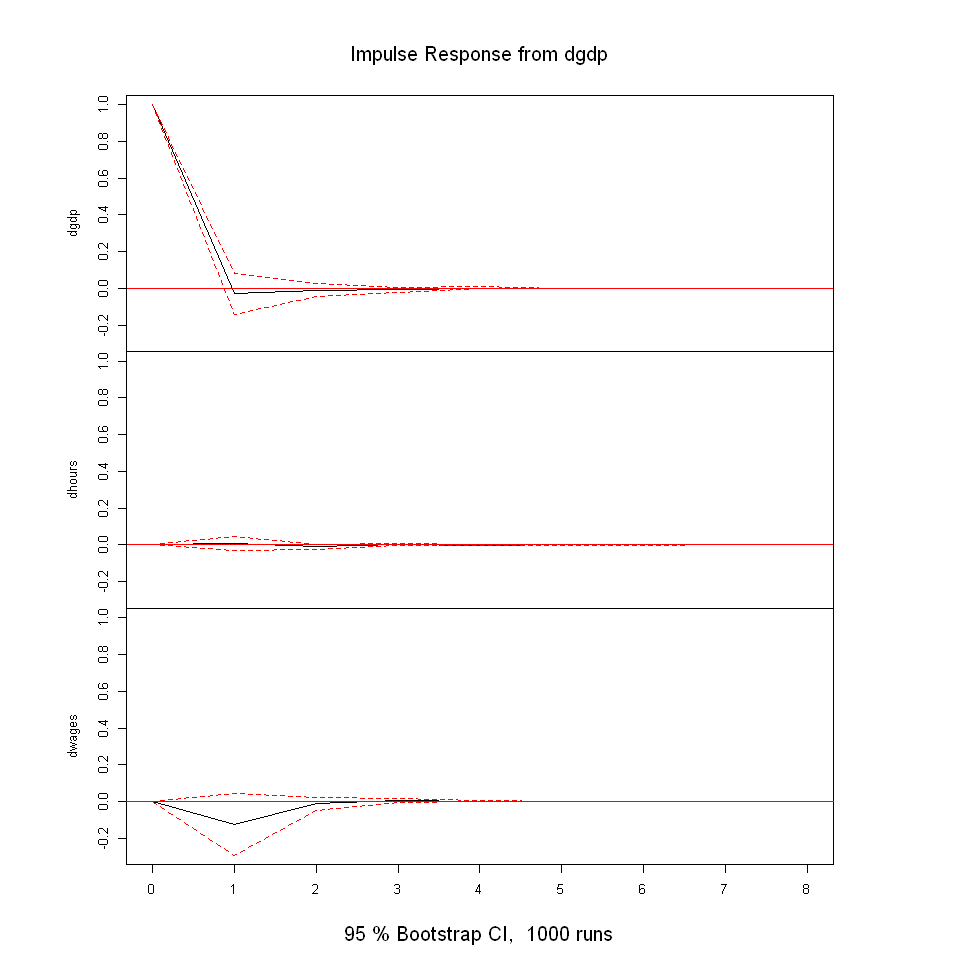

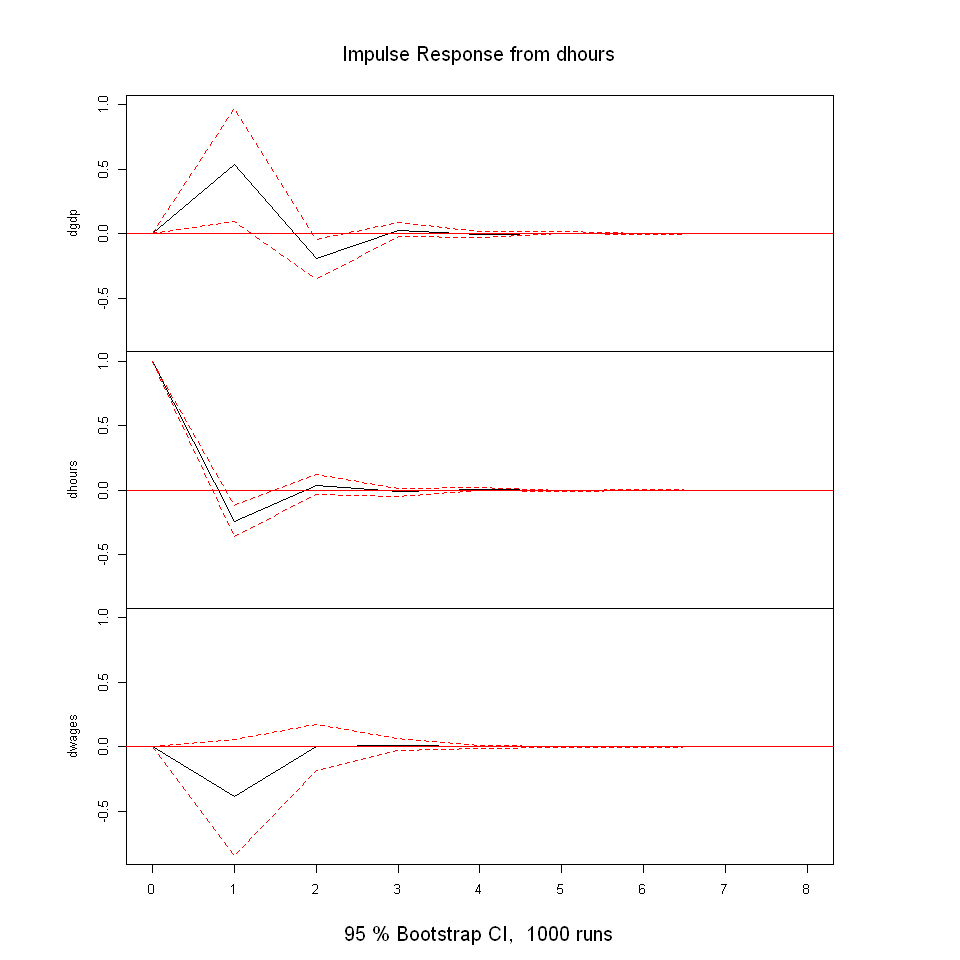

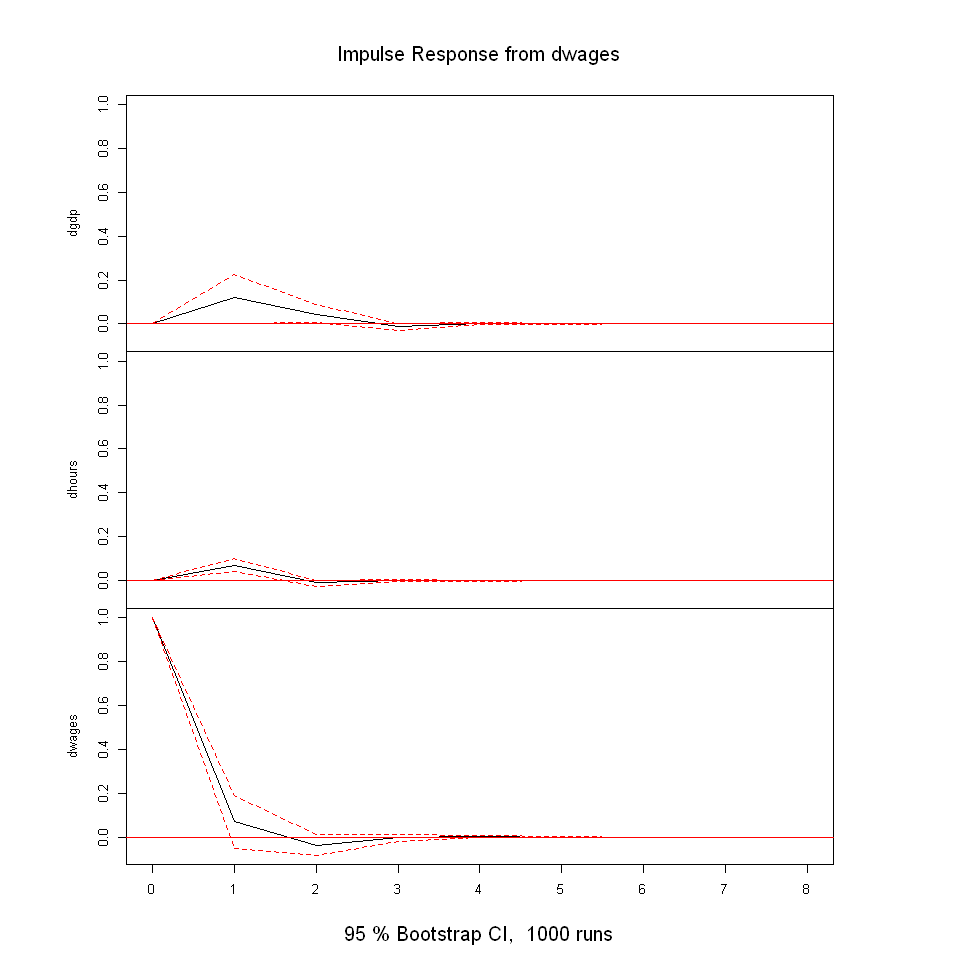

In [39]:
# Visualize impulse response functions
plot(irf.VAR1)

<div style="background-color:#e6f2ff; padding:10px; border-radius:5px;">
    
<h2>Estimation of a Structural-form VAR</h2>
    
</div>    

In [40]:
# Lower-triangular A-pattern for recursive (Cholesky) SVAR
Amat_pat = matrix(NA, 3, 3)   # NA = to be estimated
Amat_pat[1, 2] = 0            # a12 = 0: var2 ⟶ var1 (no contemporaneous effect)
Amat_pat[1, 3] = 0            # a13 = 0: var3 ⟶ var1 (no contemporaneous effect)
Amat_pat[2, 3] = 0            # a23 = 0: var3 ⟶ var2 (no contemporaneous effect)   
Amat_pat

NA,0,0
NA,NA,0
NA,NA,NA


In [41]:
# https://www.rdocumentation.org/packages/vars/versions/1.5-9/topics/SVAR
library(vars)
model.SVAR1 = SVAR(model.VAR1, Amat = Amat_pat, estmethod = "scoring", lrtest = FALSE)
names(model.SVAR1)
summary(model.SVAR1)

[1] "A"       "Ase"     "B"       "Bse"     "LRIM"    "Sigma.U" "LR"     
 [8] "opt"     "start"   "type"    "var"     "iter"    "call"


SVAR Estimation Results:

Call:
SVAR(x = model.VAR1, estmethod = "scoring", Amat = Amat_pat, 
    lrtest = FALSE)

Type: A-model 
Sample size: 249 
Log Likelihood: -918.683 
Method: scoring 
Number of iterations: 14 

Estimated A matrix:
           dgdp dhours dwages
dgdp    0.80255 0.0000 0.0000
dhours -0.23344 3.0246 0.0000
dwages -0.08255 0.2318 0.7265

Estimated standard errors for A matrix:
          dgdp dhours  dwages
dgdp   0.03596 0.0000 0.00000
dhours 0.05192 0.1355 0.00000
dwages 0.05310 0.1920 0.03256

Estimated B matrix:
       dgdp dhours dwages
dgdp      1      0      0
dhours    0      1      0
dwages    0      0      1

Covariance matrix of reduced form residuals (*100):
         dgdp dhours  dwages
dgdp   155.26 11.983  13.817
dhours  11.98 11.856  -2.421
dwages  13.82 -2.421 191.796

<div style="background-color:#e6f2ff; padding:16px 20px; border-radius:8px; line-height:1.6;">
  <h2 style="margin-top:0;">Structural-form Impulse Response</h2>

  <p>
    An <strong>impulse response function (IRF)</strong> traces out the
    <strong>dynamic effect over time</strong> of a one-time, unexpected
    <strong>structural shock</strong> to one equation on
    <strong>all variables</strong> in a VAR,
    relative to their steady states.
  </p>

  <p>
    In other words, it shows how a <strong>structural disturbance</strong> in one variable
    <strong>propagates through the system</strong>, affecting both the shocked variable itself
    and the others over subsequent periods.
  </p>
</div>


In [42]:
#https://www.rdocumentation.org/packages/vars/versions/1.5-9/topics/irf
# irf(x, impulse = NULL, response = NULL, n.ahead = 10, 
# ortho = TRUE, cumulative = FALSE, boot = TRUE, ci = 0.95, runs = 100, seed = NULL, ...)
library(vars)
irf.SVAR1 = irf(model.SVAR1, impulse = "dgdp",
                response = c("dgdp", "dhours", "dwages"),
                boot = TRUE, n.ahead = 8, seed=123)
# Responses to a shock to dgdp
irf.SVAR1$irf$dgdp


dgdp,dhours,dwages
1.246026e+00,9.616972e-02,1.108905e-01
3.240564e-02,-5.012514e-03,-1.803129e-01
-2.502939e-02,-1.106723e-02,-1.525157e-02
-7.093665e-03,1.415956e-03,6.149742e-03
1.675162e-03,2.330011e-05,7.750702e-04
6.150527e-05,6.266864e-05,-1.561343e-04
1.332324e-05,-2.560128e-05,-4.282294e-05
-1.915476e-05,3.359252e-06,4.997321e-06
2.890318e-06,-6.330166e-07,1.419063e-06


In [43]:
# Manual computation of contemporeuas responses
solve(model.SVAR1$A) 

,dgdp,dhours,dwages
dgdp,1.24602599,0.0000000,0.000000
dhours,0.09616972,0.3306247,0.000000
dwages,0.11089049,-0.1054888,1.376421


<div style="background-color:#e6f2ff; padding:16px 20px; border-radius:8px; line-height:1.6;">
  <h2 style="margin-top:0;">Interpretation of a Structural Shock</h2>

  <p>
    A <strong>Structural VAR (SVAR)</strong> goes beyond a standard reduced-form VAR by explicitly modeling the
    <strong>economic (structural) shocks</strong> that drive the system.
  </p>

  <h4>From Reduced Form to Structure</h4>
  <p>
    A reduced-form VAR looks like this:
    \[
    y_t = \sum_{i=1}^p \Phi_i y_{t-i} + u_t, \quad u_t \sim (0, \Sigma_u)
    \]
  </p>

  <ul>
    <li>\(u_t\) are <strong>residuals</strong>, but they are <strong>correlated across equations</strong>.</li>
    <li>Because they move together, we cannot interpret a single element of \(u_t\) as a separate “shock” — it may contain mixtures of multiple underlying forces.</li>
  </ul>

  <h4>Structural Representation</h4>
  <p>
    To uncover the <strong>independent economic shocks</strong>, we impose a structure:
    \[
    A y_t = B \varepsilon_t, \quad \varepsilon_t \sim (0, I)
    \]
  </p>

  <ul>
    <li>\(A\) describes <strong>how variables affect each other contemporaneously</strong>.</li>
    <li>\(B\) maps the <strong>structural shocks</strong> \(\varepsilon_t\) into the system.</li>
    <li>The shocks \(\varepsilon_t\) are <strong>independent</strong> and <strong>normalized to have unit variance</strong>.</li>
  </ul>

  <h4>Why SVAR Has Structural Shocks</h4>
  <p>
    The SVAR explicitly enforces:
    \[
    \Sigma_\varepsilon = I,
    \]
    meaning each shock is <strong>standardized</strong> and <strong>independent</strong> of the others.
  </p>

  <p>
    These are called <strong>structural shocks</strong> because they correspond to
    <strong>economically meaningful, exogenous forces</strong> — for example:
  </p>
  <ul>
    <li>a monetary policy shock,</li>
    <li>a technology shock,</li>
    <li>a demand shock.</li>
  </ul>

  <h4>Contemporaneous Effects via \(A\)</h4>
  <p>
    If \(A\) is not diagonal, variables can affect one another <strong>within the same period</strong>.<br>
    For example, a shock to GDP can <strong>instantaneously influence hours and wages</strong> through the nonzero
    off-diagonal elements of \(A^{-1}\).
  </p>

  <h4>Contemporaneous Effects via \(B\)</h4>
  <p>
    If \(B\) is not diagonal, <strong>one structural shock</strong> can immediately affect
    <strong>multiple variables</strong>. That means the shocks themselves are independent, but their effects are
    <strong>felt across several equations</strong> at once.
  </p>

  <p>For instance:</p>
  <ul>
    <li>a <strong>technology shock</strong> may affect <strong>GDP</strong>, <strong>hours</strong>, and <strong>wages</strong> simultaneously,</li>
    <li>because all three variables have nonzero loadings on that shock in the corresponding column of \(B\).</li>
  </ul>

  <p>
    In contrast, the reduced-form shocks \(u_t\) are <strong>statistical mixtures</strong> of these structural shocks.
  </p>

  <h4>Interpretation Caveats</h4>
  <p>
    In a Structural VAR, the shocks \(\varepsilon_t\) are <strong>mathematically independent</strong> — but giving them
    <strong>economic meaning</strong> (e.g., calling one a <em>technology shock</em> or a <em>demand shock</em>)
    is often <strong>nontrivial and assumption-driven</strong>.
  </p>

  <p>
    Although SVARs recover <strong>independent structural shocks</strong>,
    <strong>labeling</strong> them as specific economic forces requires
    <strong>strong identifying assumptions</strong> and <strong>economic reasoning</strong> — it cannot be inferred from the data alone.
  </p>

  <h4>Connection to Reduced-Form IRFs in R</h4>
  <p>
    The residuals \(u_t\) are <strong>correlated across equations</strong>, but R’s reduced-form IRF
    (with <code>ortho = FALSE</code>) <strong>shocks only one equation at a time</strong>.
    That is, R sets one element of \(u_t\) to 1 and the rest to 0,
    <strong>without using the covariance structure \(\Sigma_u\)</strong> to transmit the effect through correlated shocks.
  </p>

  <p>
    As a result:
  </p>
  <ul>
    <li>The reduced-form IRF <strong>traces a shock through the dynamic lag structure</strong>,</li>
    <li>but it does <strong>not model contemporaneous transmission</strong> via the correlated errors.</li>
  </ul>
</div>
   

<div style="background-color:#e6f2ff; padding:16px 20px; border-radius:8px; line-height:1.6;">
  <h2 style="margin-top:0;">Structural Interpretation of Orthogonalized Impulse Responses</h2>

  <p>
    When estimating a <strong>VAR model</strong>, we can compute
    <strong>Impulse Response Functions (IRFs)</strong> to see how each variable reacts over time
    to a one-time shock to the equation of a particular variable.
  </p>

  <p>
    If we set <code>ortho = TRUE</code> in the <code>irf()</code> function,
    the shocks are <strong>orthogonalized</strong> — that is, transformed into
    <strong>structural shocks</strong> that are independent.
    This is achieved through the <strong>Cholesky decomposition</strong>
    of the residual covariance matrix.
  </p>

  <p>
    As a result, the impulse responses can be interpreted as the
    <strong>dynamic reactions of each variable to a structural shock</strong>,
    rather than to a correlated reduced-form disturbance.
  </p>
</div>
 

In [44]:
#https://www.rdocumentation.org/packages/vars/versions/1.5-9/topics/irf
# irf(x, impulse = NULL, response = NULL, n.ahead = 10, 
# ortho = TRUE, cumulative = FALSE, boot = TRUE, ci = 0.95, runs = 100, seed = NULL, ...)
library(vars)
irf.VAR1orth = irf(model.VAR1, impulse = c("dgdp", "dhours", "dwages"), 
                   ortho = TRUE, response = c("dgdp", "dhours", "dwages"), 
                   boot = TRUE, n.ahead = 8, seed=123)
irf.VAR1orth$irf$dgdp

dgdp,dhours,dwages
1.246026e+00,9.616972e-02,1.108905e-01
3.240564e-02,-5.012514e-03,-1.803129e-01
-2.502939e-02,-1.106723e-02,-1.525157e-02
-7.093665e-03,1.415956e-03,6.149742e-03
1.675162e-03,2.330011e-05,7.750702e-04
6.150527e-05,6.266864e-05,-1.561343e-04
1.332324e-05,-2.560128e-05,-4.282294e-05
-1.915476e-05,3.359252e-06,4.997321e-06
2.890318e-06,-6.330166e-07,1.419063e-06


<div style="background-color:#e6f2ff; padding:10px; border-radius:5px;">
    
The code below is <b>tailor-made</b> to make it easier for you to plot <b>Impulse Response Functions (IRFs)</b> in a more professional and visually appealing way. 
<br>
    
<b>Enjoy!</b>
    
</div>

ℹ SHA-1 hash of file is "cb23ce6a462d73b67920ae56dc83c828d18fe7e4"


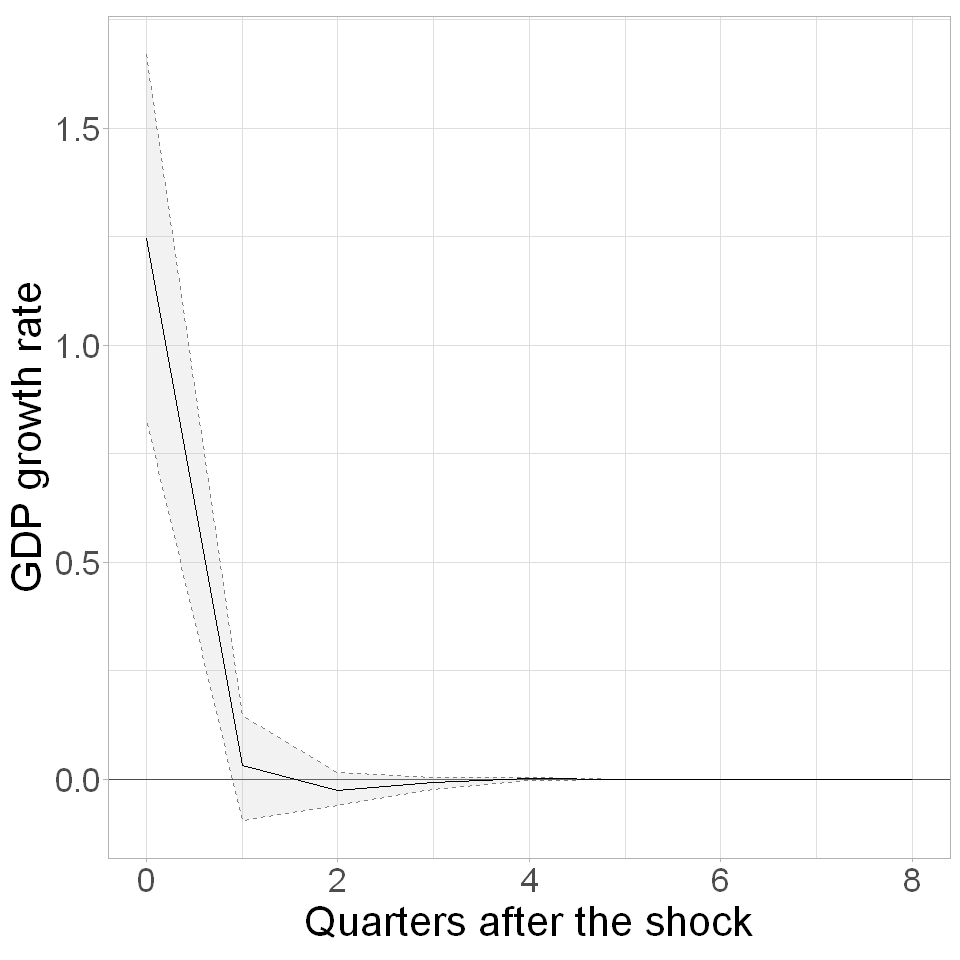

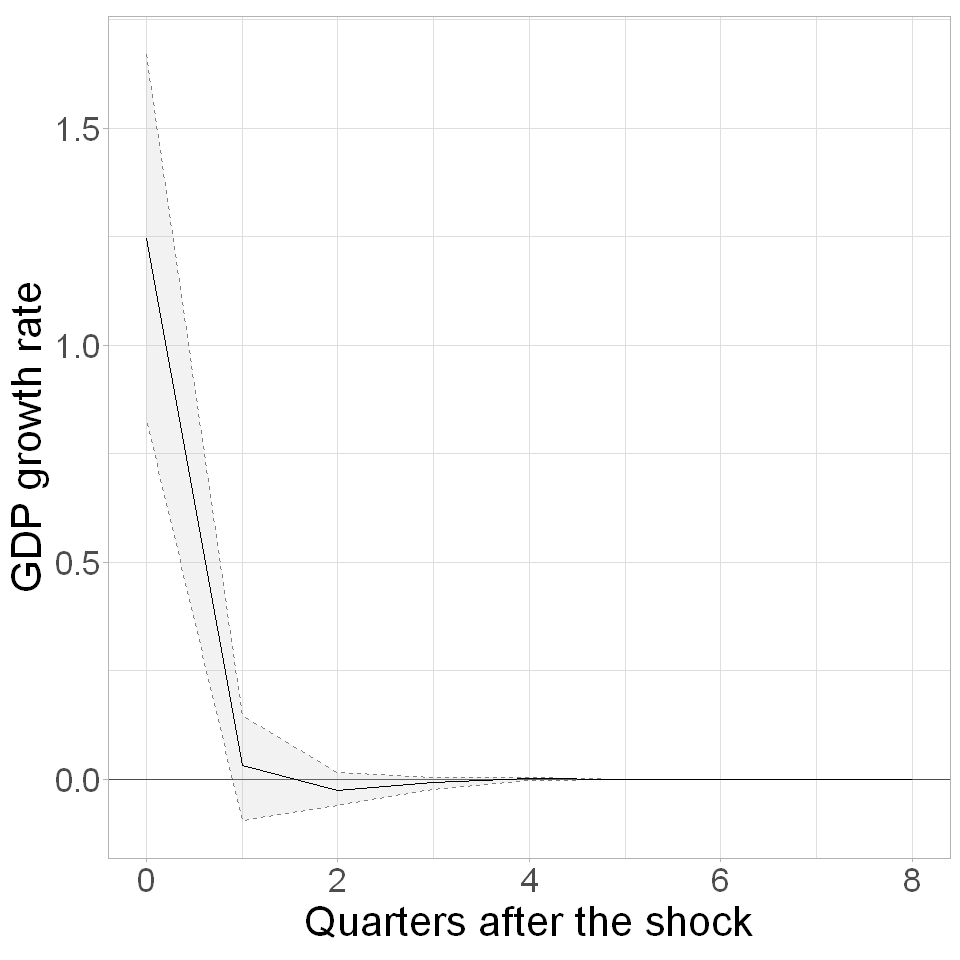

In [45]:
library(devtools)
source_url("https://raw.githubusercontent.com/anguyen1210/var-tools/master/R/extract_varirf.R");
library(dplyr)
multiple.SVAR1 = extract_varirf(irf.SVAR1)
multiple.VAR1orth = extract_varirf(irf.VAR1orth)

multiple.SVAR1 %>%
  ggplot(aes(x=period, y=irf_dgdp_dgdp, ymin=lower_dgdp_dgdp, ymax=upper_dgdp_dgdp)) +
  geom_hline(yintercept = 0, color="red") +
  geom_ribbon(fill="grey", alpha=.2, color="grey50", linetype="dashed") +
  geom_line() +
  theme_light() +
  theme(aspect.ratio=1) +
  theme(plot.margin = ggplot2::margin(0.2, 0.2, 0.2, 0.2, "cm")) +
  theme(text=element_text(size=25)) +
  labs(x = "Quarters after the shock") +
  labs(y = "GDP growth rate")
multiple.VAR1orth %>%
  ggplot(aes(x=period, y=irf_dgdp_dgdp, ymin=lower_dgdp_dgdp, ymax=upper_dgdp_dgdp)) +
  geom_hline(yintercept = 0, color="red") +
  geom_ribbon(fill="grey", alpha=.2, color="grey50", linetype="dashed") +
  geom_line() +
  theme_light() +
  theme(aspect.ratio=1) +
  theme(plot.margin = ggplot2::margin(0.2, 0.2, 0.2, 0.2, "cm")) +
  theme(text=element_text(size=25)) +
  labs(x = "Quarters after the shock") +
  labs(y = "GDP growth rate")
